# king_rook_vs_king.py

这通常是指国际象棋中的一个特定局面或末局问题。在这个局面中，一方拥有国王和车（Rook），而另一方仅有国王。这个配置是国际象棋末局策略学习的基本内容之一，因为它涉及到如何使用国王和车的组合，通过战术移动迫使对方国王达到被将死的状态。

In [1]:
# 加载依赖包
!pip install -r requirements.txt


In [2]:
# 加载数据
import pandas
import pandas as pd

data = pd.read_csv("./datasets/krkopt.data", header=None)
data.dropna(inplace=True)

print("数据样例: ", data.head())


数据样例:     0  1  2  3  4  5     6
0  a  1  b  3  c  2  draw
1  a  1  c  1  c  2  draw
2  a  1  c  1  d  1  draw
3  a  1  c  1  d  2  draw
4  a  1  c  2  c  1  draw


In [3]:
# 定义映射方法
def mapping(loc):
    if isinstance(loc, str) == True:
        return ord(loc) - 96
    else:
        return loc

In [4]:
# 数据预处理，归一化,  和棋 draw = 1, 其余的为 -1
# data.iloc[:,6] = data.iloc[:,6].apply(lambda x:1 if x == 'draw' else -1)
data.iloc[:,0] = data.iloc[:,0].apply(lambda x:mapping(x))
data.iloc[:,2] = data.iloc[:,2].apply(lambda x:mapping(x))
data.iloc[:,4] = data.iloc[:,4].apply(lambda x:mapping(x))
data.iloc[data[6]!='draw', 6] = -1
data.iloc[data[6]=='draw', 6] = 1

for i in range(6):
    data[i] = (data[i] - data[i].mean()) / data[i].std()

print(data.head())


          0         1         2         3         4         5  6
0 -2.251118 -0.921841 -1.107765 -0.662544 -0.877113 -1.090475  1
1 -2.251118 -0.921841 -0.672625 -1.538690 -0.877113 -1.090475  1
2 -2.251118 -0.921841 -0.672625 -1.538690 -0.444265 -1.535239  1
3 -2.251118 -0.921841 -0.672625 -1.538690 -0.444265 -1.090475  1
4 -2.251118 -0.921841 -0.672625 -1.100617 -0.877113 -1.535239  1


In [5]:
# 打乱样本，抽取5000样本进行训练，其余作为测试
sample_df = data.sample(frac=1, random_state=None).reset_index(drop=True)
print(sample_df.head())

          0         1         2         3         4         5   6
0 -1.183838  0.157590  0.632796  1.089749  1.287128 -0.200949  -1
1  0.950722  1.237021 -1.107765  1.527823 -1.309961 -1.090475  -1
2  0.950722  2.316452  1.067936 -1.538690  1.287128 -0.645712  -1
3  0.950722  0.157590 -0.672625 -1.538690  0.854279 -1.090475  -1
4 -1.183838 -0.921841  1.503076 -1.100617  1.287128  0.243815  -1


In [6]:
# 设置训练样本
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :6], data[6].astype(int), test_size=0.7)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_train.unique())
print(y_train.dtype)
print(y_train.shape)

(8416, 6)
(8416,)
(19640, 6)
(19640,)
[-1  1]
int64
(8416,)


In [7]:
# 设置超参数的范围
# C的取值范围是 2^-5 ~ 2^15, gamma取值范围是 2^-15 ~ 2^3
CScale = [i for i in range(100, 201, 10)] 
gammaScale = [i/10 for i in range(1, 11)]
cv_scores = 0

In [8]:
from sklearn.svm import SVC
# 训练模型
for i in CScale:
    for j in gammaScale:
        model = SVC(kernel='rbf', C = i, gamma = j)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        if scores.mean() > cv_scores:
            cv_scores = scores.mean()
            savei = i;
            savej = j * 100
print(savei)
print(savej)
    

KeyboardInterrupt: 

In [9]:
# 训练一个确定参数的模型
model = SVC(kernel = 'rbf', C=1176.3, gamma=0.0625)
model.fit(X_train, y_train)
pre = model.predict(X_test)
model.score(X_test, y_test)

0.9940936863543788

<Figure size 640x480 with 0 Axes>

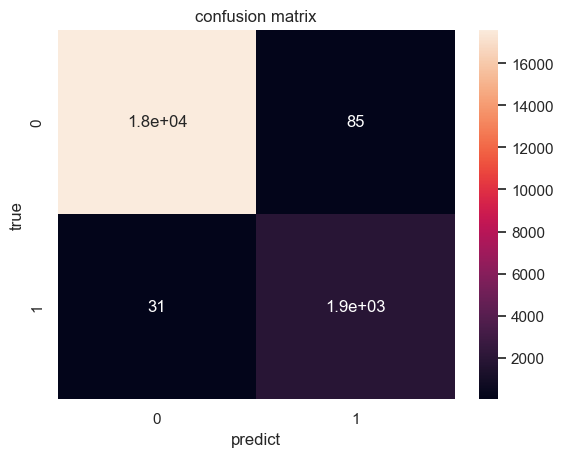

<Figure size 640x480 with 0 Axes>

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, pre, labels=[-1, 1], sample_weight=None)
sns.set()
f, ax=plt.subplots()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)
plt.figure()

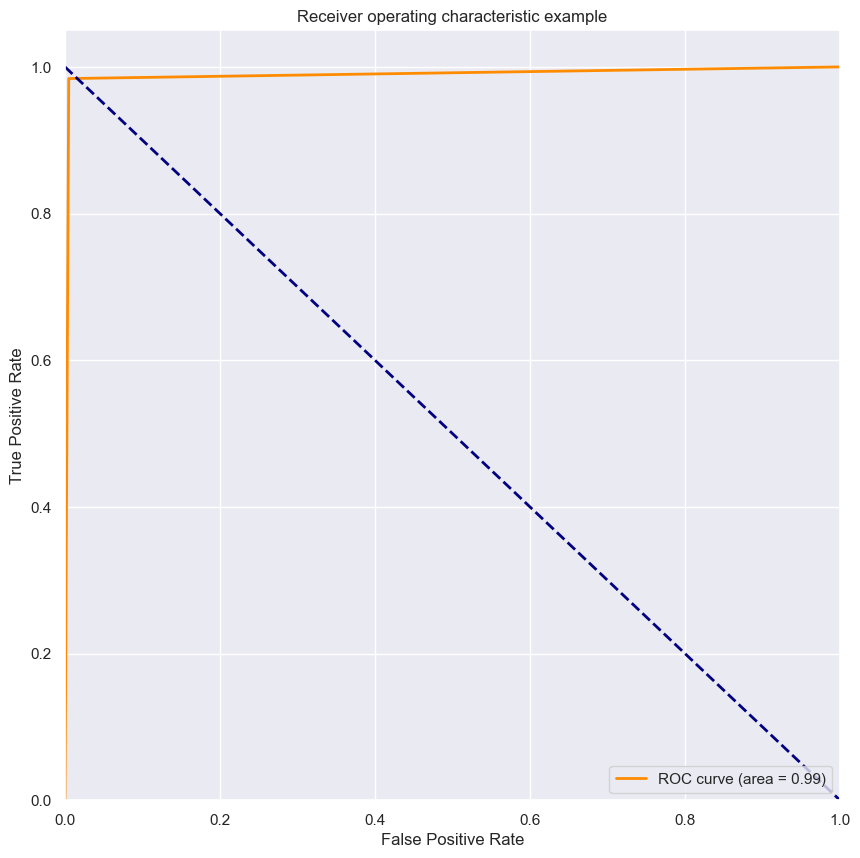

In [11]:
lw=2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()